# Семинар по ганам

In [13]:
import torch
from torch import nn
import numpy as np

torch.manual_seed(0)

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output

In [14]:
torch.__version__

'1.4.0+cpu'

# Define samplers

In [15]:
# inspired by: https://github.com/togheppi/vanilla_GAN/blob/master/1D_Gaussian_GAN_pytorch.py#L10

# Data distribution
class DataDistribution:
    def __init__(self, mu, sigma):
        self.mu = mu
        self.sigma = sigma

    def sample(self, num_samples):
        samples = torch.empty(num_samples).normal_(mean=self.mu,
                                                   std=self.sigma)[:, None]
        return samples


# Noise distribution
class NoiseDistribution:
    def __init__(self, data_range):
        self.data_range = data_range

    def sample(self, num_samples):
        samples = torch.rand(num_samples, 1)
        return samples

# Define networks

In [16]:
class Generator(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        
        """
        Определите двухслойную полносвязную нейросеть с нелинейности.
        Инициализируйте линейные свои нормальным распределением
        Инициализируйте сдвиги нулями.
        
        """
        
        self.input_layer = nn.Linear(input_dim, hidden_dim)
        torch.nn.init.normal_(self.input_layer.weight)
        torch.nn.init.constant_(self.input_layer.bias, 0.)
        
        self.nonlinearity = nn.ReLU()
        
        self.output_layer = nn.Linear(hidden_dim, output_dim)
        torch.nn.init.normal_(self.output_layer.weight)
        torch.nn.init.constant_(self.output_layer.bias, 0.)
        
        
    def forward(self, x):
        x = self.input_layer(x)
        x = self.nonlinearity(x)
        x = self.output_layer(x)
        return x
        
    
class Discriminator(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        
        """
        Определите двухслойную полносвязную нейросеть с нелинейности.
        Инициализируйте линейные свои нормальным распределением
        Инициализируйте сдвиги нулями.
        
        """
        
        self.input_layer = nn.Linear(input_dim, hidden_dim)
        torch.nn.init.normal_(self.input_layer.weight)
        torch.nn.init.constant_(self.input_layer.bias, 0.)
        
        self.nonlinearity = nn.ReLU()
        
        self.output_layer = nn.Linear(hidden_dim, output_dim)
        torch.nn.init.normal_(self.output_layer.weight)
        torch.nn.init.constant_(self.output_layer.bias, 0.)
        
    def forward(self, x):
        x = self.input_layer(x)
        x = self.nonlinearity(x)
        x = self.output_layer(x)
        return x

In [17]:
hidden_size = 32
learning_rate = 0.001

# инициализируйте генератор и дискриминатор
G = Generator(1, hidden_size, 1)
D = Discriminator(1, hidden_size, 1)

# инициализируйте ортимизаторы
D_optimizer = torch.optim.SGD(D.parameters(), lr=learning_rate)
G_optimizer = torch.optim.SGD(G.parameters(), lr=learning_rate)

In [18]:
mu = 5.0
sigma = 1.5
data_range = 10
batch_size = 150

data_distributor = DataDistribution(mu, sigma)
noise_distributor = NoiseDistribution(data_range)

# Training routine

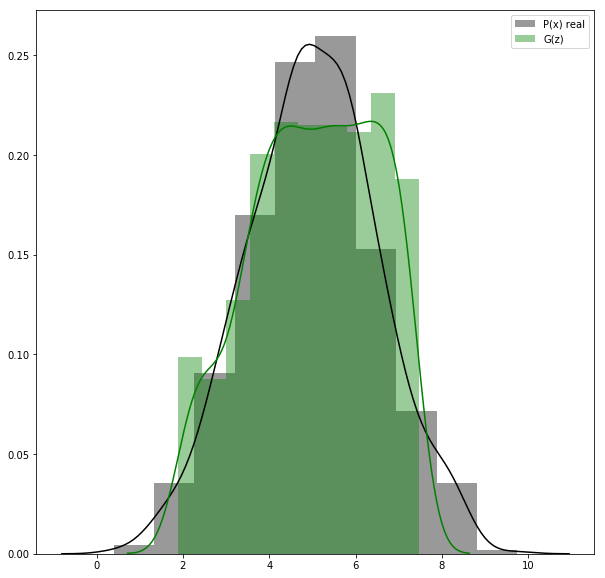

In [19]:
# инициализируйте лосс
criterion = torch.nn.BCEWithLogitsLoss()

D_train_iters = 5

D_losses = []
G_losses = []

for i in range(10000):

    for j in range(D_train_iters):
        # sample real data
        real_samples = data_distributor.sample(batch_size)
        # get discrtiminator preds on real data
        preds_real = D(real_samples)
        
        # get generated data
        with torch.no_grad():
            noise_samples = noise_distributor.sample(batch_size)
            generated_samples = G(noise_samples)
        # get discrtiminator preds on generated data
        preds_generated = D(generated_samples)
        
        #cоздайте массив с целевыми значениями
        targets = torch.cat((torch.ones_like(preds_real),
                               torch.zeros_like(preds_generated)))
        
        D_loss = criterion(torch.cat((preds_real, preds_generated)), targets)
        
        # propagate gradients
        D_optimizer.zero_grad()
        D_loss.backward()
        D_optimizer.step()
        
    # generate data
    noise_samples = noise_distributor.sample(batch_size)
    generated_samples = G(noise_samples)
        
    preds_generated = D(generated_samples)
    G_loss = criterion(preds_generated, torch.ones_like(preds_generated))
    D_losses.append(D_loss)
    G_losses.append(G_loss)
    
    G_optimizer.zero_grad()
    G_loss.backward()
    G_optimizer.step()
    
    if i % 200 == 0:
        with torch.no_grad():
            generated_data = G(noise_distributor.sample(1000))
        real_data = data_distributor.sample(1000)
        clear_output()
        plt.figure(figsize=(10, 10))
        sns.distplot(real_data.data.numpy(), color='black', label='Р(x) real', bins=10)
        sns.distplot(generated_data.data.numpy(), color='green', label='G(z)', bins=10)
        plt.legend()
        plt.show()

# Посмотрим на ошибку

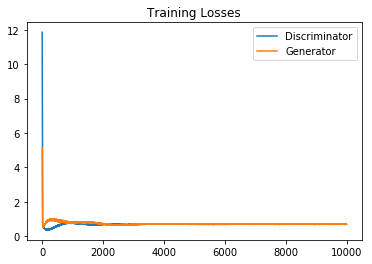

In [20]:
# Plot losses
fig, ax = plt.subplots()
D_losses = np.array(D_losses)
G_losses = np.array(G_losses)
plt.plot(D_losses, label='Discriminator')
plt.plot(G_losses, label='Generator')
plt.title("Training Losses")
plt.legend()
plt.show()

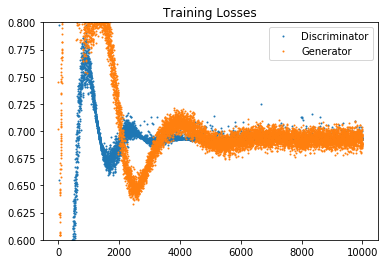

In [27]:
# Plot losses
fig, ax = plt.subplots()
D_losses = np.array(D_losses)
G_losses = np.array(G_losses)
plt.plot(D_losses, 'o', markersize=1, label='Discriminator')
plt.plot(G_losses, 'o', markersize=1, label='Generator')
plt.title("Training Losses")
plt.ylim([0.6, 0.8])
plt.legend()
plt.show()